GoogLeNet: 含并行连结的网络
下图为GoogLeNet中重要的技术: 并行的Inception块
蓝色块用于数据提取, 白色块用于通道数的改变

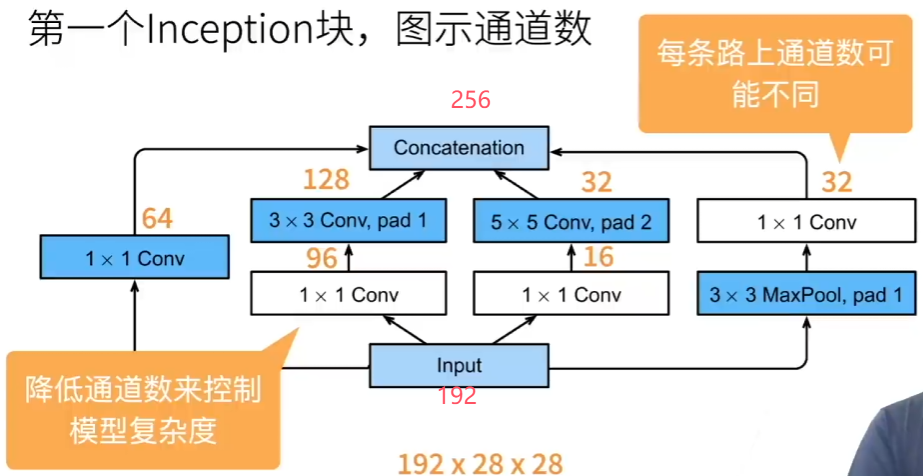

跟单3x3或5x5卷积层比，Inception块有更少的参数个数和计算复杂度

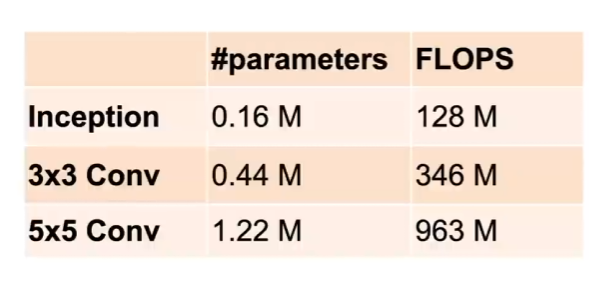

GoogLeNet的全貌: 5个stage, 9个inception块

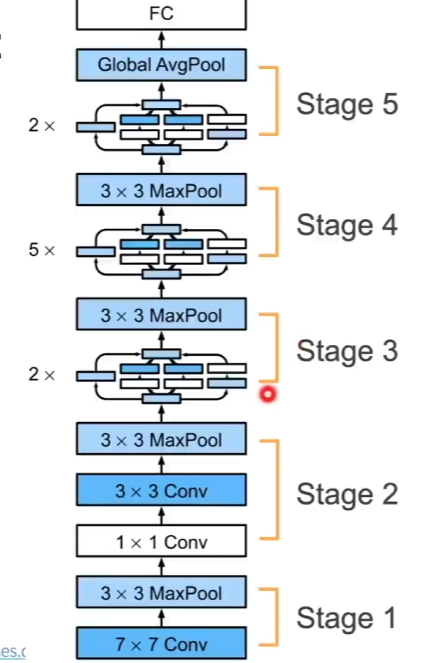

Stage1&2: 更小的窗口, 保留更多高宽

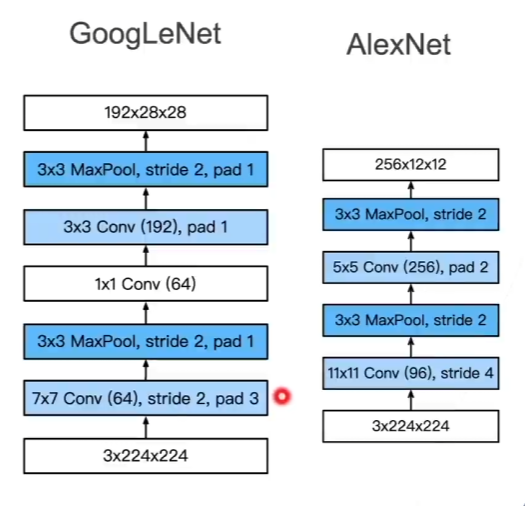

stage3: 两个inception块, 增加通道数

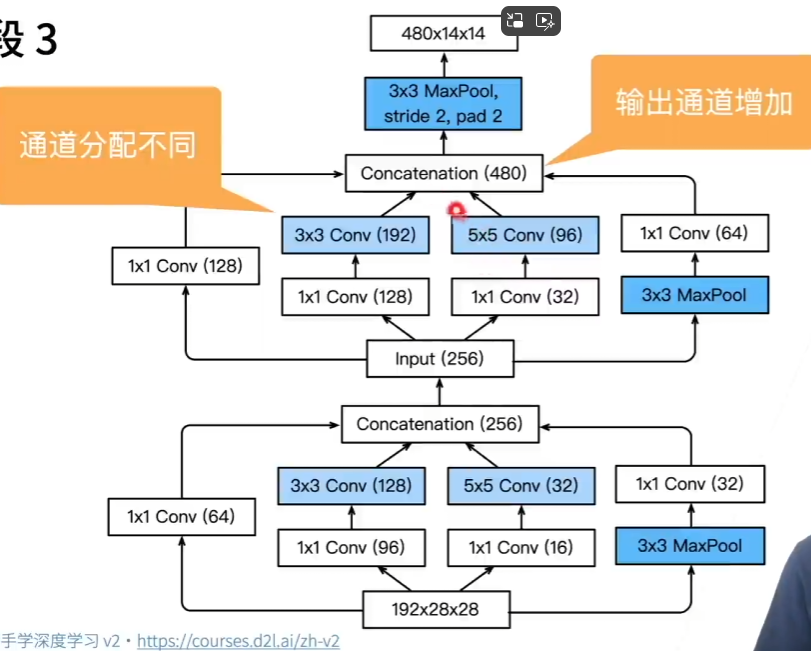

Stage4&5: 仍然在不断增加通道数, 最终形成1024维特征输出

inception有很多变种和更新:
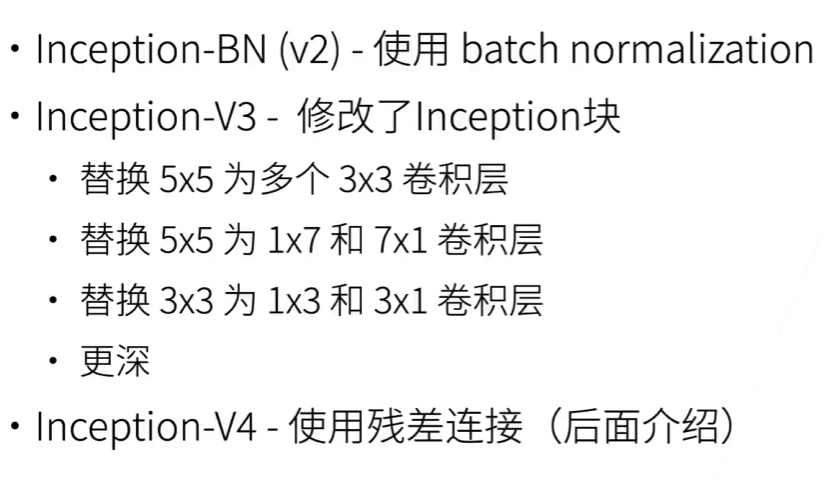

总结
·Inception块用4条有不同超参数的卷积层和池化层的路来抽取不同的信息
·它的一个主要优点是模型参数小，计算复杂度低
·GoogleNet使用了9个Inception块，是第一个达到上百层的网络
·后续有一系列改进

补充: 一个标准的nn.Conv2d的参数
torch.nn.Conv2d(
    in_channels,      # 输入通道数
    out_channels,     # 输出通道数
    kernel_size,      # 卷积核尺寸
    stride=1,         # 步长
    padding=0,        # 填充
    dilation=1,       # 空洞率
    groups=1,         # 分组卷积
    bias=True,        # 是否使用偏置
    padding_mode='zeros',  # 填充模式
    device=None,      # 设备
    dtype=None        # 数据类型
)

In [ ]:
# 代码实现
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
# 定义一个继承自 nn.Module 的 Inception 模块
class Inception(nn.Module):
    # 该模块包含四个并行分支，每个分支处理输入并产生特征图，最终在通道维度（dim=1）拼接输出
    # cn 代表了out_channels
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # in_channels → c1: 通过 1x1 卷积将输入通道压缩或扩展到 c1
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 作用：先通过 1x1 卷积降维，再通过 3x3 卷积提取特征
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 先通过 1x1 卷积降维，再通过 5x5 卷积提取特征。
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        # 分支1：直接对输入 x 进行 1x1 卷积 + ReLU 激活。
        p1 = F.relu(self.p1_1(x))
        # 分支2：输入 x → 1x1 卷积 + ReLU → 3x3 卷积 + ReLU。
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        # 分支3：输入 x → 1x1 卷积 + ReLU → 5x5 卷积 + ReLU。
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        # 分支4：输入 x → 3x3 最大池化 → 1x1 卷积 + ReLU。
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 拼接输出：将四个分支的输出在通道维度 (dim=1) 拼接，形成多尺度融合的特征图。
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
# 利用分支网络的整体网络构造
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2,
                                           padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [ ]:
# 网络展示
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [ ]:
# 训练过程
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())